# Predicting Child Separation Using Anomaly Detection on 2021-2023 MSNA Data (excluding outlier CAR 2021)

## 1. Data Exploration

This script performs several data exploration tasks on the MSNA data 2021-2023 (`msna_data.csv`):

**Steps:**

1. **Loading and Initial Exploration**:
   - The dataset is loaded, and the number of rows and columns is displayed.

2. **Data Filtering**:
   - Missing values in the `child_sep_severity` column are removed to ensure data quality.
   - MSNA data for the outlier CAR 2021 is removed

3. **Encoding Categorical Variables for EDA**:
   - Categorical variables are transformed into numeric format using label encoding to ensure that the data can be processed numerically for analysis.

4. **Correlation Analysis**:
   - A function performs various correlation analyses (Pearson, Spearman, Kendall Tau) between all variables and the target variable (`child_sep_severity_family_reun_required`).
   - The script also calculates skewness (measure of asymmetry) and the Variance Inflation Factor (VIF) to detect multicollinearity (if variables are too highly correlated with each other).

5. **Frequency Check for MSNA Variable**:
   - The frequency distribution of the `msna` variable (a categorical column) is checked, and the results are visualized in a bar plot.

6. **Export Results**:
   - The results of the correlation and exploratory analysis are saved to an Excel file.
   - The data is also saved as a pickle file for future use.

Number of rows and columns in the data: (329443, 199)
Number of rows and columns in the data after excluding car 2021 and droping NAs for child separation: (257494, 199)
                                         Variable  Pearson Correlation  \
60    child_sep_severity_all_family_reun_required             1.000000   
64                    child_sep_reasons_given_yes             0.182996   
9                         child_sep_reasons_given             0.182996   
57                    children_outside_hh_all_yes             0.182996   
55                        children_outside_hh_yes             0.182996   
..                                            ...                  ...   
63                     child_sep_reasons_given_no            -0.182996   
54                         children_outside_hh_no            -0.182996   
61  child_sep_severity_all_no_children_outside_hh            -0.182996   
8                          child_sep_severity_all            -0.209742   
7               

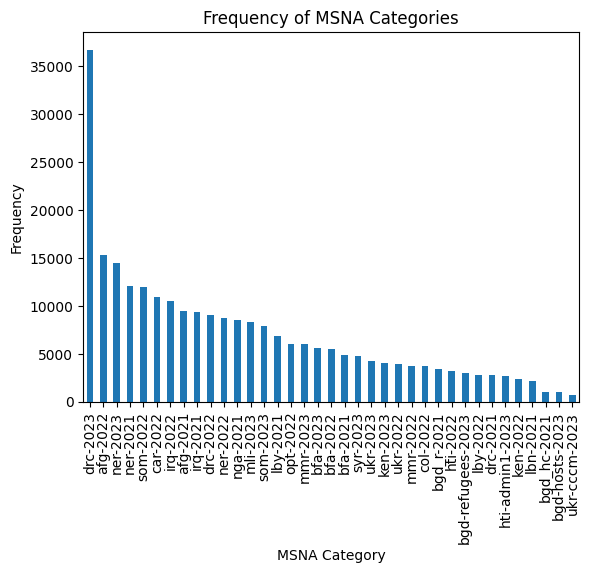

In [2]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

# Show the number of rows and columns of the data
print("Number of rows and columns in the data:", data.shape)

# Filter out rows with missing values in the 'child_sep_severity' column
data = data.dropna(subset=['child_sep_severity'])

# Filter out rows where 'msna' is 'car-2021'
data = data[data['msna'] != 'car-2021']

# Show the number of rows and columns of the data
print("Number of rows and columns in the data after excluding car 2021 and droping NAs for child separation:", data.shape)

# Label encode any categorical variables to ensure no NaNs during conversion (just for the sake of data exploration)
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()

# Save the loaded data as pickle file
data.to_pickle('data_raw.pkl')


## 2. Data Splitting

This script processes a dataset containing normal cases (Class 0) and anomalies (Class 1). The aim is to prepare the data for machine learning by splitting it into training, validation, and test sets, followed by separating features (X) and the target variable (y).

**Steps:**

1. **Loading the Data**:
   - The dataset is loaded from a pickle file (`data_raw.pkl`), and the target column is identified as `child_sep_severity_family_reun_required`.

2. **Splitting Data into Normal and Anomalous Classes**:
   - The data is divided into two groups: normal cases (Class 0) and anomalies (Class 1).

3. **Splitting Class 0 (Normal Cases) Data**:
   - The normal data (Class 0) is split into training (80%), validation (10%), and test (10%) sets.
   
4. **Splitting Class 1 (Anomalous Cases) Data**:
   - Since anomalies are not used for training, they are split evenly into validation and test sets.

5. **Combining Class 0 and Class 1 for Validation and Test Sets**:
   - The validation and test sets are created by combining normal and anomalous cases.

6. **Separating Features (X) and Target Variable (y)**:
   - Features (`X_train`, `X_val`, `X_test`) and the target variable (`y_train`, `y_val`, `y_test`) are separated for all splits.

7. **Saving the Data**:
   - The feature and target sets for training, validation, and test data are saved as pickle files for later use.


In [3]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the raw data
with open('data_raw.pkl', 'rb') as f:
    data = pickle.load(f)

# Define the target column
target_column = 'child_sep_severity_family_reun_required'

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###
# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
data_class0 = data[data[target_column] == 0]  # DataFrame for class 0
data_class1 = data[data[target_column] == 1]  # DataFrame for class 1

print(f"Total samples in Class 0 (Normal): {data_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {data_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###
# Split class 0 data into training (80%) and temporary set (20%)
train_class0, temp_class0 = train_test_split(data_class0, test_size=0.2, random_state=42)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
val_class0, test_class0 = train_test_split(temp_class0, test_size=0.5, random_state=42)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {train_class0.shape[0]}")
print(f"  Validation samples: {val_class0.shape[0]}")
print(f"  Test samples: {test_class0.shape[0]}")

### 3. Split Class 1 Data (Anomalies) into Validation and Test Sets ###
# Since we don't use anomalies for training, split class 1 data into validation and test sets
val_class1, test_class1 = train_test_split(data_class1, test_size=0.5, random_state=42)

print("\nClass 1 Data Splits (Anomalies):")
print(f"  Validation samples: {val_class1.shape[0]}")
print(f"  Test samples: {test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###
# Validation Set: Combine class 0 and class 1 validation data
val_data = pd.concat([val_class0, val_class1])

# Test Set: Combine class 0 and class 1 test data
test_data = pd.concat([test_class0, test_class1])

# Ensure the indices are aligned
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###
# Training set contains only class 0 (normal cases)
train_data = train_class0

# Ensure indices are aligned for consistency
train_data.reset_index(drop=True, inplace=True)

### 6. Split into X (features) and y (target) for Training, Validation, and Test Sets ###
# Training set
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

# Validation set
X_val = val_data.drop(columns=[target_column])
y_val = val_data[target_column]

# Test set
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

# Save the features and target for training, validation, and test sets as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

### 7. Print the Structure of the Resulting Splits ###
print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")



Total samples in Class 0 (Normal): 256814
Total samples in Class 1 (Anomalies): 680

Class 0 Data Splits:
  Training samples: 205451
  Validation samples: 25681
  Test samples: 25682

Class 1 Data Splits (Anomalies):
  Validation samples: 340
  Test samples: 340

Training Set (Only Class 0 - Normal Cases)
  Features: 198
  Samples: 205451
  Class 0: 205451
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 198
  Samples: 26021
  Class 0: 25681
  Class 1: 340

Test Set (Class 0 and Class 1)
  Features: 198
  Samples: 26022
  Class 0: 25682
  Class 1: 340


## 3. Data Cleaning

This script performs data cleaning on training, validation, and test sets by removing columns with excessive missing values, zero variance, and irrelevant suffixes, preparing the feature sets (`X`) for model training.

**Steps:**

1. **Loading Data**:
   - The feature sets (`X_train`, `X_val`, `X_test`) and target sets (`y_train`, `y_val`, `y_test`) are loaded from pickle files.
   - A list of relevant variables is loaded from a CSV file (`vars_analysis.csv`), and only these variables are retained in the datasets.

2. **Detecting Columns to Drop**:
   - **Missing Values**: Columns with more than 20% missing values are identified and marked for removal.
   - **Zero Variance**: Columns with zero variance (those with only one unique value) are detected and flagged for removal.
   - **'_NA' Suffix**: Columns ending with '_NA' are identified as irrelevant and marked for deletion.

3. **Dropping the Detected Columns**:
   - Columns identified in the previous step are dropped from the feature sets (`X_train`, `X_val`, and `X_test`).
   - The script prints the dimensions of the datasets before and after the cleaning process to track the changes.

4. **Visualizing Missing Data**:
   - The missing data matrix is visualized for the cleaned training, validation, and test sets using `missingno`, providing a graphical representation of missing values.

5. **Saving the Cleaned Data**:
   - The cleaned feature sets (`X_train_cleaned`, `X_val_cleaned`, `X_test_cleaned`) are saved as pickle files for future use.
   - The target sets (`y_train`, `y_val`, `y_test`) are saved separately and remain unaffected by the cleaning process.



Detected columns to drop:
['fatalities_3m', 'received_assistance_12m_dnk', 'fatalities_1y', 'hoh_age', 'wgq_dis_3_n', 'wgq_dis_4_n', 'displ_status_specific_idp_site', 'received_assistance_12m_dwta', 'events_1y', 'received_assistance_3m_dwta', 'displ_status_specific_idp_returnee', 'received_assistance_6m_yes', 'fsl_fc_cell', 'wgq_dis_2_n', 'received_assistance_12m_yes', 'events_3m', 'lcsi_cat', 'displ_status_specific_idp_non_site', 'fatalities_6m', 'received_assistance_6m_dwta', 'rcsi_score', 'events_6m', 'received_assistance_3m_dnk', 'received_assistance_6m_dnk', 'received_assistance_3m_yes']
Number of rows and columns in X_train: (205451, 38)
Number of rows and columns in X_val: (26021, 38)
Number of rows and columns in X_test: (26022, 38)

Number of rows and columns in X_train_cleaned: (205451, 13)
Number of rows and columns in X_val_cleaned: (26021, 13)
Number of rows and columns in X_test_cleaned: (26022, 13)

Training set after dropping columns with too many NAs and zero variance

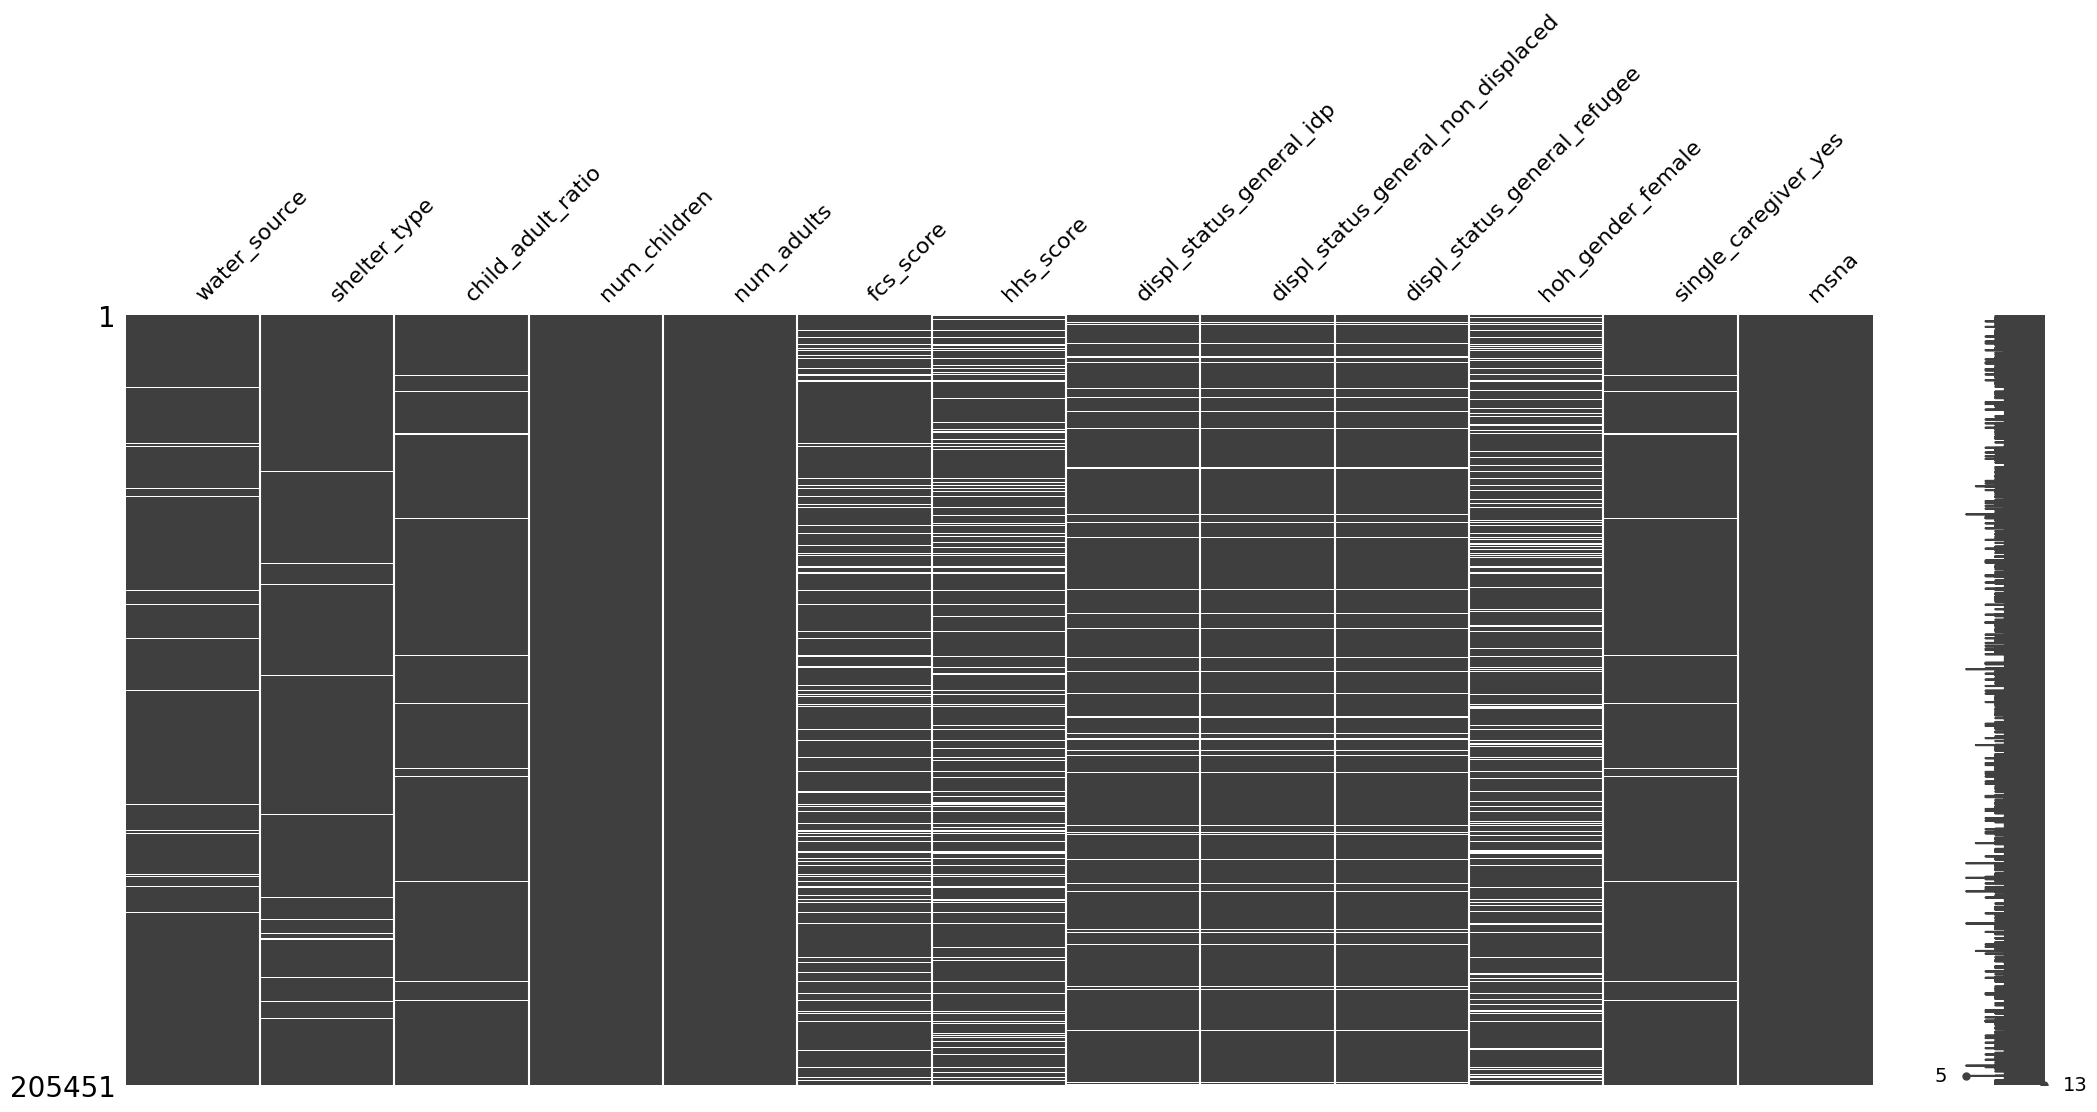


Validation set after dropping columns:


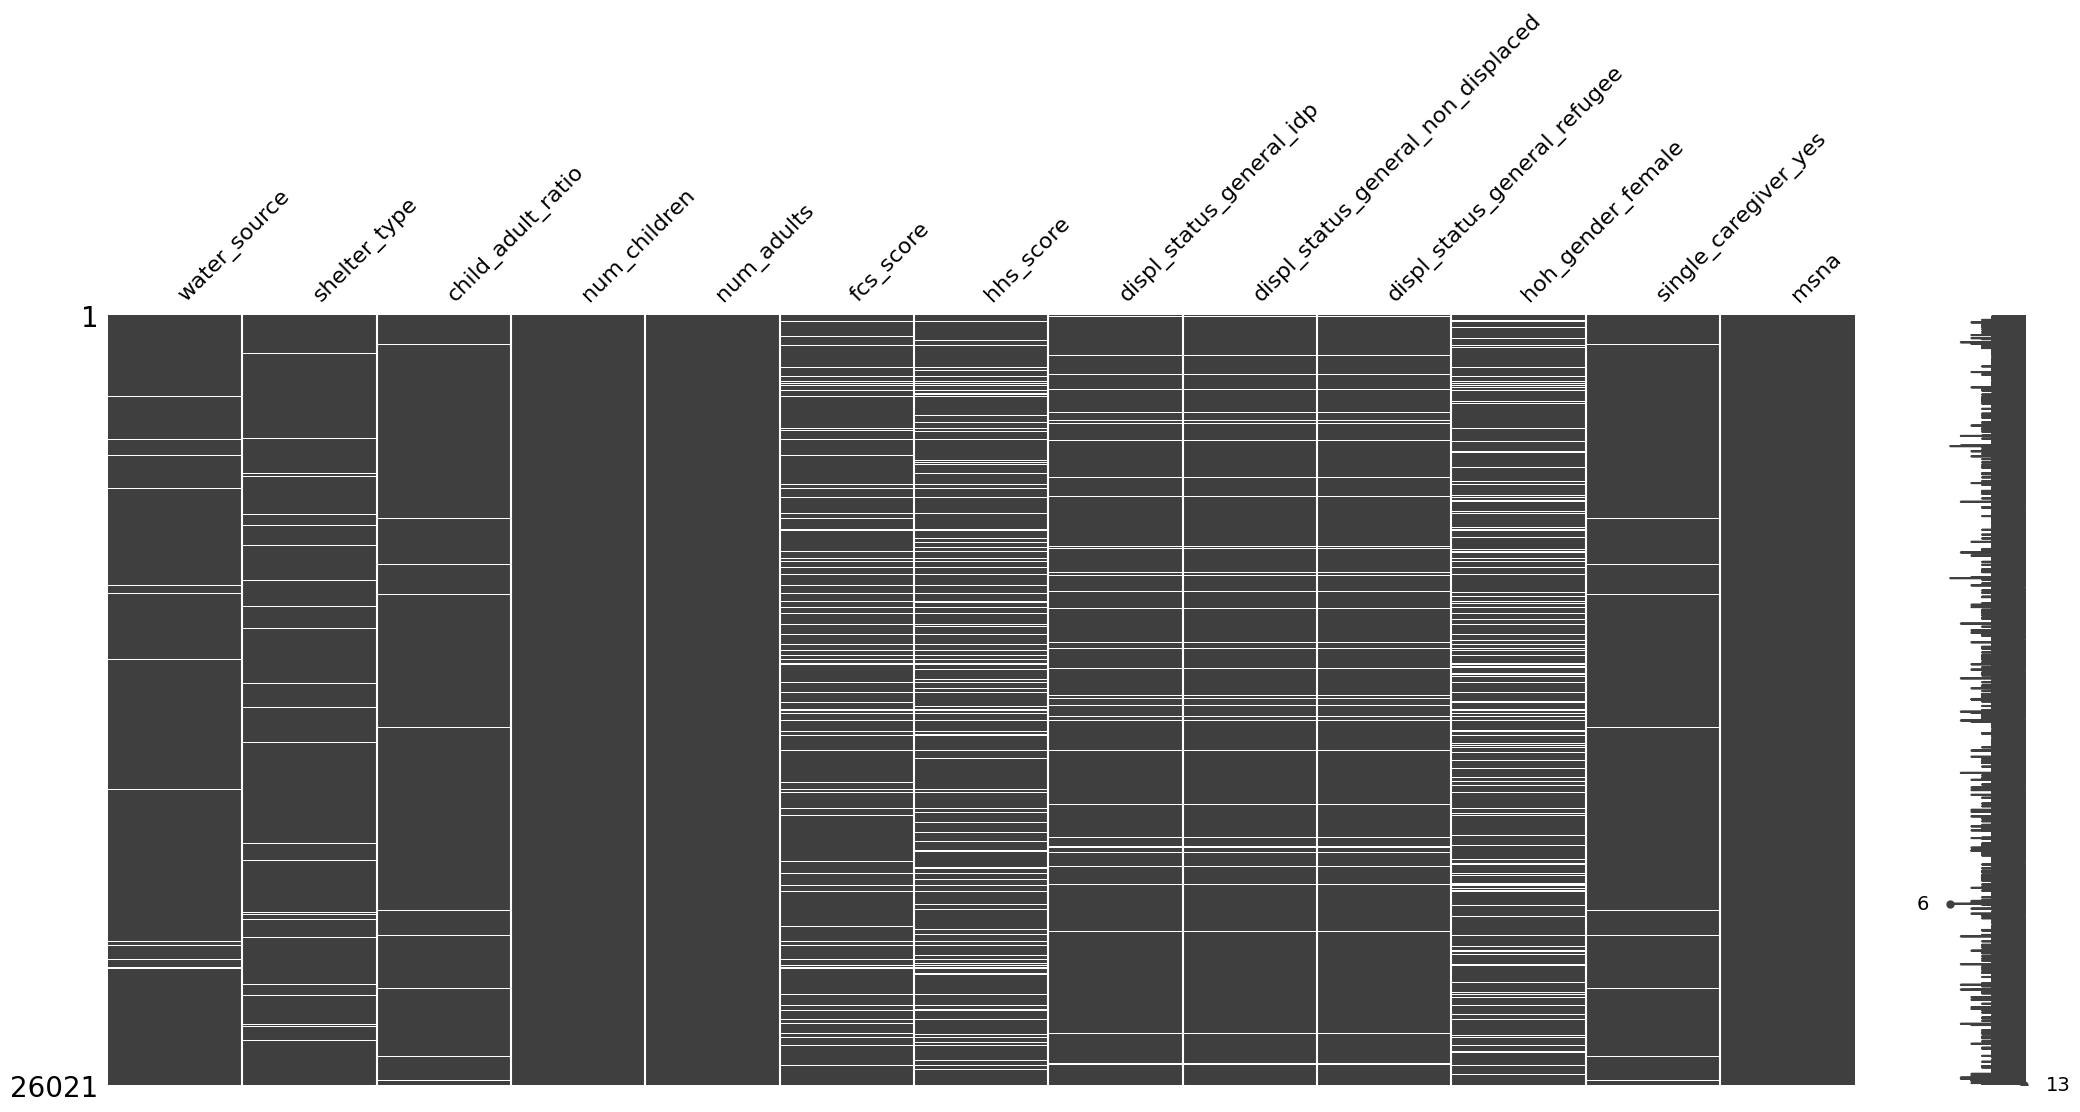


Test set after dropping columns:


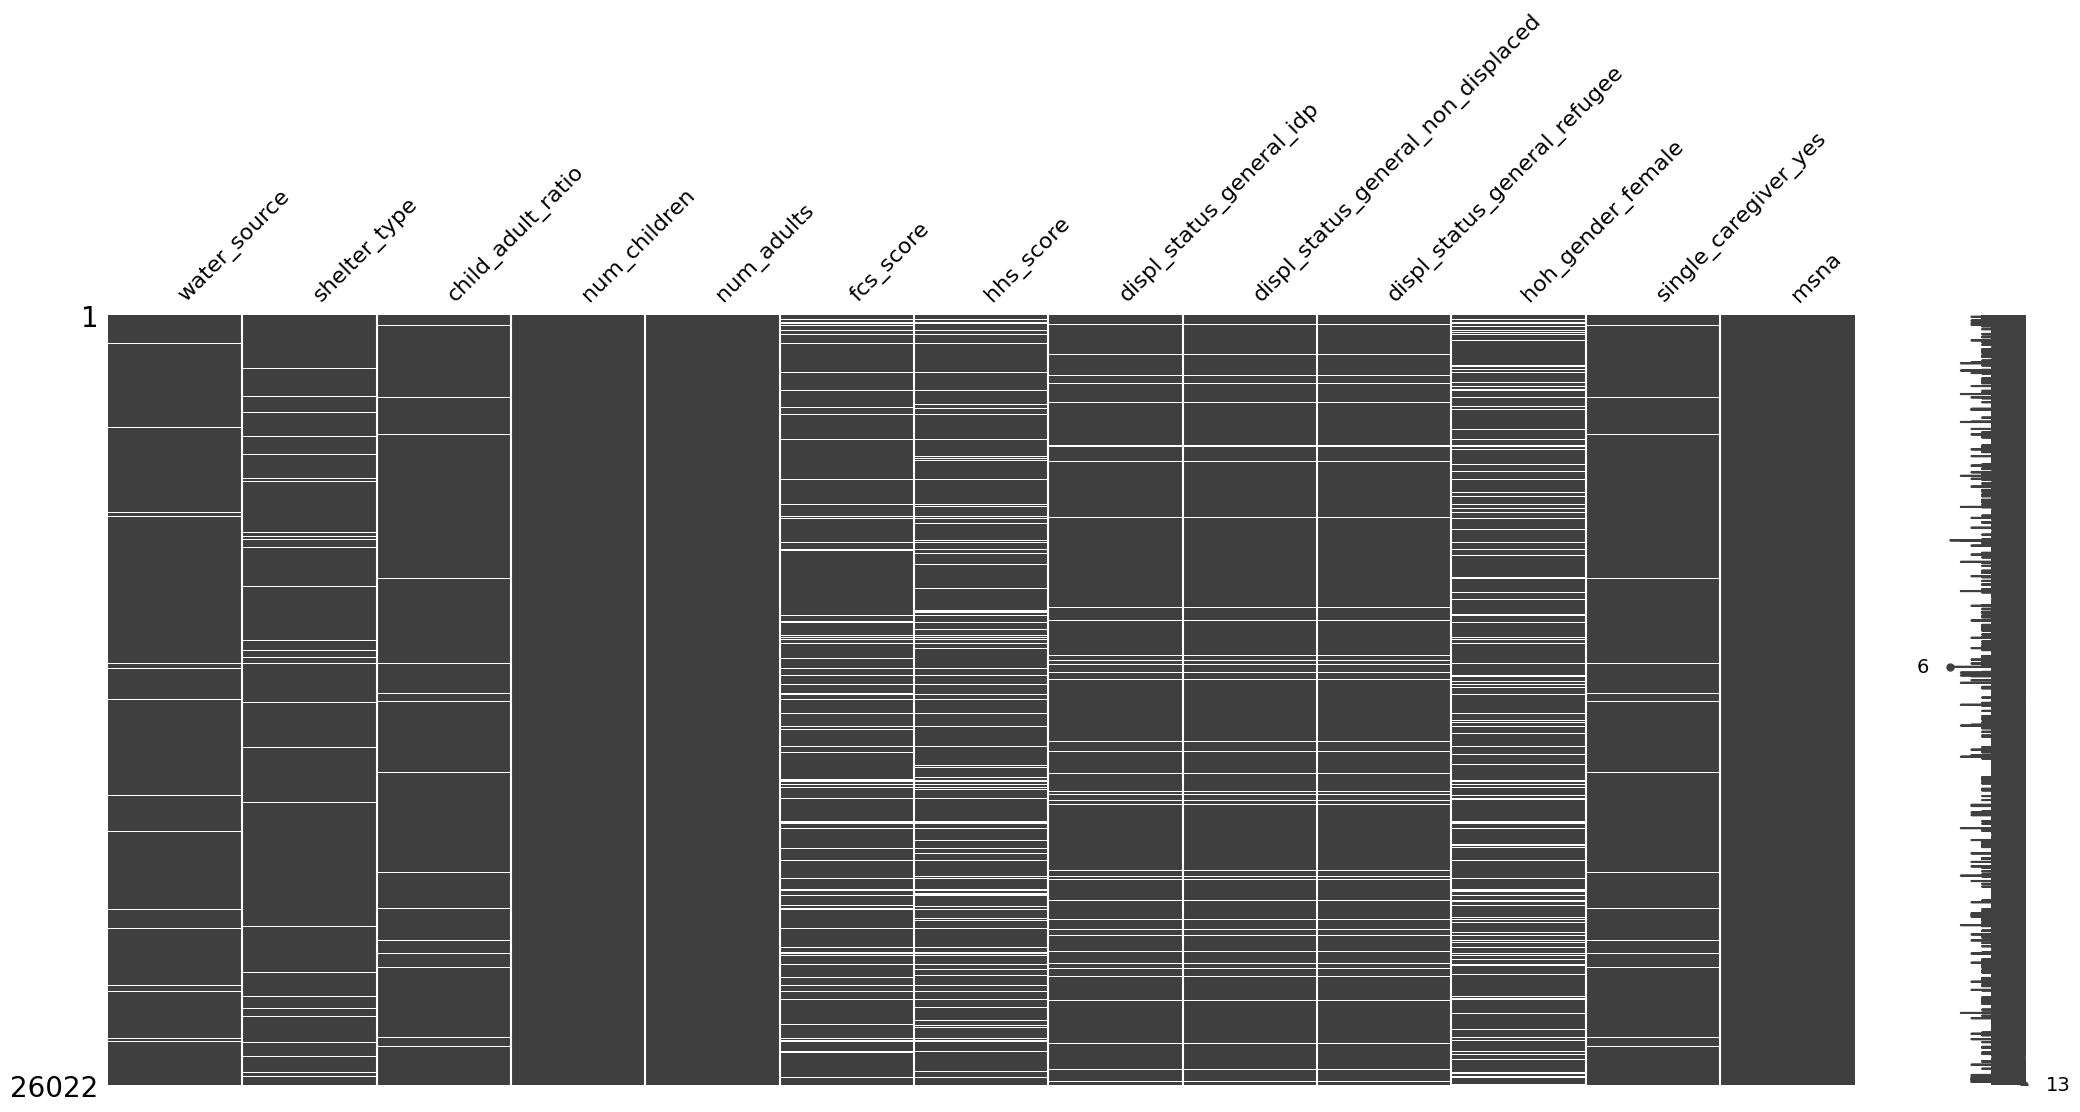

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import pickle

# Load the X (features) and y (target) sets for training, validation, and test sets
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Load the list of variables to consider for the model (features only)
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()
vars_analysis = [var for var in vars_analysis if var in X_train.columns]

# Exclude irrelevant columns by keeping only relevant features (X) in the datasets
X_train = X_train[vars_analysis].copy()
X_val = X_val[vars_analysis].copy()
X_test = X_test[vars_analysis].copy()

### Step 1: Detect columns to drop (more than 20% missing values, zero variance, columns ending with '_NA') ###

# Identify columns with more than 20% missing values
missing_percentage = X_train.isnull().mean() * 100
columns_with_many_missing = missing_percentage[missing_percentage > 20].index.tolist()

# Identify columns with zero variance
zero_variance_columns = X_train.nunique()
columns_with_zero_variance = zero_variance_columns[zero_variance_columns <= 1].index.tolist()

# Identify columns ending with '_NA'
na_columns = [col for col in X_train.columns if col.endswith('_NA')]

### Combine all detected columns to drop ###
columns_to_drop = list(set(columns_with_many_missing + columns_with_zero_variance + na_columns))

# Print all detected columns to drop
print("\nDetected columns to drop:")
print(columns_to_drop)

### Step 2: Drop the detected columns ###

# Drop columns from the X datasets (features only)
X_train_cleaned = X_train.drop(columns=columns_to_drop, errors='ignore')
X_val_cleaned = X_val.drop(columns=columns_to_drop, errors='ignore')
X_test_cleaned = X_test.drop(columns=columns_to_drop, errors='ignore')

# Show the number of rows and columns for each dataset before cleaning
print("Number of rows and columns in X_train:", X_train.shape)
print("Number of rows and columns in X_val:", X_val.shape)
print("Number of rows and columns in X_test:", X_test.shape)

# Show the number of rows and columns for each dataset after cleaning
print("\nNumber of rows and columns in X_train_cleaned:", X_train_cleaned.shape)
print("Number of rows and columns in X_val_cleaned:", X_val_cleaned.shape)
print("Number of rows and columns in X_test_cleaned:", X_test_cleaned.shape)

# Visualize the remaining missing data in the cleaned training set
print("\nTraining set after dropping columns with too many NAs and zero variance:")
msno.matrix(X_train_cleaned)
plt.show()

# Ensure that indices are reset for consistency in validation and test sets
X_val_cleaned.reset_index(drop=True, inplace=True)
X_test_cleaned.reset_index(drop=True, inplace=True)

# Visualize the missing data in the validation and test sets
print("\nValidation set after dropping columns:")
msno.matrix(X_val_cleaned)
plt.show()

print("\nTest set after dropping columns:")
msno.matrix(X_test_cleaned)
plt.show()

### Step 3: Save the cleaned data for X (features) and retain y (target) ###
with open('X_train_cleaned.pkl', 'wb') as f:
    pickle.dump(X_train_cleaned, f)
with open('X_val_cleaned.pkl', 'wb') as f:
    pickle.dump(X_val_cleaned, f)
with open('X_test_cleaned.pkl', 'wb') as f:
    pickle.dump(X_test_cleaned, f)

# Ensure y (target) is saved separately and remains unaffected by the cleaning process
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)


## 4. Feature Engineering 

This script performs feature engineering on training, validation, and test datasets by applying label encoding, log transformations, and creating a new variable based on the `msna` category. It ensures consistency across all datasets and excludes irrelevant variables before saving the transformed data.

**Steps:**

1. **Loading Data**:
   - The cleaned training, validation, and test datasets (`X_train_cleaned`, `X_val_cleaned`, `X_test_cleaned`) along with target sets (`y_train`, `y_val`, `y_test`) are loaded from pickle files.

2. **Loading New Labels**:
   - A CSV file (`new_labels.csv`) is loaded, containing old and new labels for specific variables. These labels are then filtered to match the columns present in the training data.

3. **Applying Label Mapping**:
   - Label encoding is applied to relevant variables in the training dataset. The labels are mapped from old to new values as specified in the CSV file.

4. **Log Transformations**:
   - Specific variables (e.g., `fcs_score`, `hhs_score`) undergo log transformations to handle skewed distributions, adding a small constant to avoid log of zero.

6. **Applying the Same Transformations to Validation and Test Sets**:
   - The same label mapping and log transformations are applied to the validation and test datasets to maintain consistency.

7. **Ensuring Consistent Columns Across Datasets**:
   - The script ensures that the training, validation, and test datasets have the same columns by intersecting the columns of the three datasets. The `msna` variable is excluded from all datasets.

8. **Saving the Transformed Datasets**:
   - The transformed datasets (`X_fe_train`, `X_fe_val`, `X_fe_test`) are saved as pickle files for future use.


In [5]:
import pandas as pd
import pickle

# Load the cleaned training, validation, and test datasets produced from the previous cleaning step
with open('X_train_cleaned.pkl', 'rb') as f:
    X_train_cleaned = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_val_cleaned.pkl', 'rb') as f:
    X_val_cleaned = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('X_test_cleaned.pkl', 'rb') as f:
    X_test_cleaned = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Load the new_labels CSV file and filter for variables present in the training data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(X_train_cleaned.columns)]

# Print old and new labels after relabeling
print("\nOld and New Labels after Relabeling:")
print(new_labels)

# Apply label mapping to the training data
X_fe_train = X_train_cleaned.copy()

for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in X_fe_train.columns:
        X_fe_train[variable] = X_fe_train[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in X_fe_train.columns:
        X_fe_train[variable] = X_fe_train[variable].fillna(pd.NA).astype('Int64')

# Apply log transformation to specific variables in the training data if they exist in the dataset
log_transform_vars = ['fcs_score', 'hhs_score', 'rcsi_score', 'fsl_fc_cell']

for var in log_transform_vars:
    if var in X_fe_train.columns:
        # Log transform the variable, adding a small constant (1) to avoid log(0)
        X_fe_train[f'{var}_log'] = np.log(X_fe_train[var] + 1)

# Apply the same transformations to the validation and test datasets
X_fe_val = X_val_cleaned.copy()
X_fe_test = X_test_cleaned.copy()

# Apply label mapping and log transformations to validation and test sets
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])

    if variable in X_fe_val.columns:
        X_fe_val[variable] = X_fe_val[variable].replace(label_old, label_new)
    
    if variable in X_fe_test.columns:
        X_fe_test[variable] = X_fe_test[variable].replace(label_old, label_new)

# Apply log transformations to validation and test datasets
for var in log_transform_vars:
    if var in X_fe_val.columns:
        X_fe_val[f'{var}_log'] = np.log(X_fe_val[var] + 1)
    
    if var in X_fe_test.columns:
        X_fe_test[f'{var}_log'] = np.log(X_fe_test[var] + 1)

# Ensure all three datasets (train, val, test) have the same columns
common_columns = X_fe_train.columns.intersection(X_fe_val.columns).intersection(X_fe_test.columns)
X_fe_train = X_fe_train[common_columns]
X_fe_val = X_fe_val[common_columns]
X_fe_test = X_fe_test[common_columns]

# Exclude 'msna' variable from all datasets
X_fe_train = X_fe_train.drop(columns=['msna'], errors='ignore')
X_fe_val = X_fe_val.drop(columns=['msna'], errors='ignore')
X_fe_test = X_fe_test.drop(columns=['msna'], errors='ignore')

# Save the transformed datasets
X_fe_train.to_pickle('X_fe_train.pkl')
X_fe_val.to_pickle('X_fe_val.pkl')
X_fe_test.to_pickle('X_fe_test.pkl')

# Print the structure of each DataFrame
print("\nStructure of X_fe_train:")
print(X_fe_train.info())

print("\nStructure of X_fe_val:")
print(X_fe_val.info())

print("\nStructure of X_fe_test:")
print(X_fe_test.info())

# Output final confirmation
print("Training, validation, and test sets have been transformed and saved.")



Old and New Labels after Relabeling:
       variable      label_old  label_new
0  shelter_type       adequate          1
1  shelter_type     inadequate          2
2  shelter_type     no_shelter          3
3  water_source       improved          1
4  water_source     unimproved          2
5  water_source  surface_water          3


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_9432\1634959857.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fe_train[variable] = X_fe_train[variable].replace(label_old, label_new)
C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_9432\1634959857.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fe_val[variable] = X_fe_val[variable].replace(label_old, label_new)
C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_9432\1634959857.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be rem


Structure of X_fe_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205451 entries, 0 to 205450
Data columns (total 14 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   water_source                        201054 non-null  Int64  
 1   shelter_type                        200637 non-null  Int64  
 2   child_adult_ratio                   202162 non-null  float64
 3   num_children                        205450 non-null  float64
 4   num_adults                          205446 non-null  float64
 5   fcs_score                           184235 non-null  float64
 6   hhs_score                           177135 non-null  float64
 7   displ_status_general_idp            194821 non-null  float64
 8   displ_status_general_non_displaced  194821 non-null  float64
 9   displ_status_general_refugee        194821 non-null  float64
 10  hoh_gender_female                   174724 non-null  float64
 11  

## 5. Imputation of Missing Values


In [ ]:
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Load the cleaned training, validation, and test datasets produced from the previous cleaning step
with open('X_fe_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_fe_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('X_fe_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Function to apply KNN Imputation to training set and use it on validation and test sets
def knn_impute_train_test_val(X_train, X_val, X_test, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit the imputer on the training data
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

    # Apply the imputer (already fit on the training data) to validation and test sets
    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    return X_train_imputed, X_val_imputed, X_test_imputed

# Apply KNN imputation to training, validation, and test sets
X_train_imputed, X_val_imputed, X_test_imputed = knn_impute_train_test_val(X_train, X_val, X_test)

# Identify binary columns (those with only two unique values: 0 and 1, or 1.0 and 0.0, including missing values)
binary_columns = [col for col in X_train.columns if X_train[col].dropna().nunique() == 2 and set(X_train[col].dropna().unique()).issubset({0, 1, 0.0, 1.0})]

# Identify integer columns
integer_columns = X_train.select_dtypes(include=['int64']).columns.tolist()

# Add binary columns to integer columns, ensuring no duplicates
integer_columns = list(set(integer_columns + binary_columns))

# Print the integer columns
print("Integer columns:", integer_columns)

# Ensure rounding is applied only to numeric columns that can be rounded
numeric_columns_to_round = [col for col in integer_columns if col in X_train_imputed.columns and pd.api.types.is_numeric_dtype(X_train_imputed[col])]

# Round the integer variables to ensure no impossible values are imputed
X_train_imputed[numeric_columns_to_round] = X_train_imputed[numeric_columns_to_round].round()
X_val_imputed[numeric_columns_to_round] = X_val_imputed[numeric_columns_to_round].round()
X_test_imputed[numeric_columns_to_round] = X_test_imputed[numeric_columns_to_round].round()

# Visualize missing data matrix after imputation on training set
msno.matrix(X_train_imputed)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nTraining DataFrame with imputed values:")
print(X_train_imputed.head())

# Save the imputed DataFrames as pickle files
with open('X_train_imputed.pkl', 'wb') as f:
    pickle.dump(X_train_imputed, f)
with open('X_val_imputed.pkl', 'wb') as f:
    pickle.dump(X_val_imputed, f)
with open('X_test_imputed.pkl', 'wb') as f:
    pickle.dump(X_test_imputed, f)


## 6. Create Interaction Terms

This script performs K-Nearest Neighbors (KNN) imputation to handle missing values in the training, validation, and test datasets. After imputation, the script ensures that binary and integer variables are correctly rounded. The imputed datasets are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The cleaned training, validation, and test datasets (`X_fe_train`, `X_fe_val`, `X_fe_test`) are loaded from pickle files.

2. **KNN Imputation**:
   - A custom function `knn_impute_train_test_val` is defined to apply KNN imputation on the training data and then use the trained imputer to fill missing values in the validation and test datasets. The imputation is performed using 5 nearest neighbors by default.

3. **Imputation Application**:
   - KNN imputation is applied to the training, validation, and test datasets using the function, resulting in imputed versions of the datasets (`X_train_imputed`, `X_val_imputed`, `X_test_imputed`).

4. **Identifying Binary and Integer Columns**:
   - The script identifies binary columns (with values 0/1 or similar) and integer columns from the training dataset.
   - The identified integer columns are updated to include the binary columns, ensuring no duplicates.

5. **Rounding Integer Variables**:
   - After imputation, the script ensures that the values in integer and binary columns are correctly rounded to avoid impossible values (e.g., decimals in binary columns).

6. **Visualizing Missing Data**:
   - The missing data in the training set is visualized using a matrix plot, showing where missing values were present and imputed.

7. **Saving Imputed Datasets**:
   - The imputed versions of the training, validation, and test datasets are saved as pickle files (`X_train_imputed.pkl`, `X_val_imputed.pkl`, `X_test_imputed.pkl`) for future use.


In [ ]:
import pandas as pd

# Load the imputed datasets (training, validation, and test)
X_train_imputed = pd.read_pickle('X_train_imputed.pkl')
X_val_imputed = pd.read_pickle('X_val_imputed.pkl')
X_test_imputed = pd.read_pickle('X_test_imputed.pkl')

# Work with copies of the loaded data to avoid changing the originals
X_train_inter = X_train_imputed.copy()
X_val_inter = X_val_imputed.copy()
X_test_inter = X_test_imputed.copy()

# Identify numeric columns in the training set for interaction
numeric_columns = X_train_inter.select_dtypes(include=['int64', 'float64']).columns

# Create interaction terms between 'msna_cluster' and all other numeric variables in the training set
for column in numeric_columns:
    if column != 'msna_car_2021':  # Skip interaction of msna_cluster with itself
        interaction_column_name = f'{column}_x_msna_car_2021'
        
        # Interaction for the training set
        X_train_inter[interaction_column_name] = X_train_inter[column] * X_train_inter['msna_car_2021']
        
        # Apply the same interaction transformation to validation and test sets
        X_val_inter[interaction_column_name] = X_val_inter[column] * X_val_inter['msna_car_2021']
        X_test_inter[interaction_column_name] = X_test_inter[column] * X_test_inter['msna_car_2021']

# Print the number of new interaction terms added in the training set
num_new_columns = len([col for col in X_train_inter.columns if '_x_msna_car_2021' in col])
print(f"\nNumber of new interaction terms added: {num_new_columns}")

# Print the structure of the training DataFrame
print("\nStructure of the Training DataFrame after adding interaction terms:")
print(X_train_inter.info())

# Save the modified datasets with interaction terms to new pickle files
X_train_inter.to_pickle('X_train_inter.pkl')
X_val_inter.to_pickle('X_val_inter.pkl')
X_test_inter.to_pickle('X_test_inter.pkl')

# Inspect the new columns added to the modified training data
new_columns = [col for col in X_train_inter.columns if '_x_msna_car_2021' in col]
print("\nNew Columns with Interaction Terms:")
print(new_columns)

# Show the first 5 rows of the new columns with interaction terms in the training set
print("\nFirst 5 rows of the new columns with interaction terms (Training Set):")
print(X_train_inter[new_columns].head())


## 7. Data Standardization

This script applies standardization to numerical variables in the training, validation, and test datasets. It ensures that numerical variables are scaled to have a mean of 0 and a standard deviation of 1. The standardized datasets are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The training, validation, and test sets (`X_train_inter`, `X_val_inter`, `X_test_inter`) are loaded from pickle files.

2. **Identifying Numerical Variables**:
   - The script reads the `vars_analysis.csv` file to identify which variables are numerical.
   - It also identifies columns in the datasets that either contain "log" in their name or are substrings of numerical variable names.
   - The combined list of numerical variables is filtered to ensure that only those present in the data are selected.

3. **Standardization**:
   - A `StandardScaler` is used to standardize the numerical variables in the training dataset (`X_train_inter`), ensuring that they have a mean of 0 and a standard deviation of 1.
   - The same scaler is then applied to the validation and test sets to maintain consistency.

4. **Saving Standardized Data**:
   - The standardized training, validation, and test datasets are saved as pickle files (`X_train_stand.pkl`, `X_val_stand.pkl`, `X_test_stand.pkl`).

5. **Displaying Statistics**:
   - The script displays summary statistics for the numerical variables in the training dataset, both before and after standardization, to show the effect of the scaling process.

6. **Visualization**:
   - Histograms are created for a specific variable (`child_adult_ratio`) to visually compare its distribution before and after standardization in the training set.

In [ ]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the training, validation, and test sets
with open('X_train_inter.pkl', 'rb') as f:
    X_train_inter = pickle.load(f)
with open('X_val_inter.pkl', 'rb') as f:
    X_val_inter = pickle.load(f)
with open('X_test_inter.pkl', 'rb') as f:
    X_test_inter = pickle.load(f)

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Standardize the numerical variables
scaler = StandardScaler()

# Identify columns that contain "log" in their name from training data
log_columns = [col for col in X_train_inter.columns if "log" in col]

# Identify columns in training data that contain any of the numerical_variables as a substring
substring_columns = []
for var in numerical_variables:
    substring_columns.extend([col for col in X_train_inter.columns if var in col])

# Combine both lists (log_columns and substring_columns) with the initial numerical_variables, ensuring no duplicates
combined_numerical_vars = list(set(numerical_variables + log_columns + substring_columns))

# Filter numerical variables that are actually present in the DataFrames
numerical_variables = [var for var in combined_numerical_vars if var in X_train_inter.columns]

# Print the filtered numerical variables to standardize
print("Numerical variables to standardize:")
print(numerical_variables)

# Standardize the training data
X_train_stand = X_train_inter.copy()
X_train_stand[numerical_variables] = scaler.fit_transform(X_train_stand[numerical_variables])

# Apply the same standardization to the validation and test sets (using the same scaler fit on the training set)
X_val_stand = X_val_inter.copy()
X_val_stand[numerical_variables] = scaler.transform(X_val_stand[numerical_variables])

X_test_stand = X_test_inter.copy()
X_test_stand[numerical_variables] = scaler.transform(X_test_stand[numerical_variables])

# Save the standardized DataFrames as pickle files
with open('X_train_stand.pkl', 'wb') as f:
    pickle.dump(X_train_stand, f)
with open('X_val_stand.pkl', 'wb') as f:
    pickle.dump(X_val_stand, f)
with open('X_test_stand.pkl', 'wb') as f:
    pickle.dump(X_test_stand, f)

# Display summary statistics before and after standardization for the training set
print("\nSummary statistics before standardization (numerical variables only, training set):")
print(X_train_inter[numerical_variables].describe())
print("\nSummary statistics after standardization (numerical variables only, training set):")
print(X_train_stand[numerical_variables].describe())

# Display histograms before and after standardization for a specific variable
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(X_train_inter['child_adult_ratio'], bins=30, alpha=0.7, color='blue')
plt.title('child_adult_ratio before standardization (Training Set)')

plt.subplot(1, 2, 2)
plt.hist(X_train_stand['child_adult_ratio'], bins=30, alpha=0.7, color='green')
plt.title('child_adult_ratio after standardization (Training Set)')

plt.tight_layout()
plt.show()


## 8. Feature Selection

This script performs feature selection on standardized training, validation, and test datasets. It identifies and removes highly correlated features while preserving key transformed variables like log-transformed features and binary (`_yes`) columns. The selected features are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The standardized training, validation, and test sets are loaded from pickle files (`X_train_stand.pkl`, `X_val_stand.pkl`, `X_test_stand.pkl`).
   - The target variable (`y_train.pkl`) is also loaded to verify the correct target column.

2. **Correlation Analysis**:
   - A correlation matrix is calculated for the training dataset.
   - The script identifies highly correlated features, with a correlation threshold set at 0.9.
   - For log-transformed columns, if the original version of the feature is highly correlated with its log-transformed counterpart, the original feature is dropped.
   - For binary (`_yes`) columns, if a column has a counterpart (`_no`) that is highly correlated, the counterpart is dropped.

3. **Removing Highly Correlated Features**:
   - The identified highly correlated features are removed from the training dataset (`X_train_fs`), and the same features are dropped from the validation and test datasets.

4. **Ensuring Consistency Across Datasets**:
   - The script ensures that the same features remain in the training, validation, and test datasets by keeping only the common columns in all three sets.

5. **Saving Selected Features**:
   - The selected features for the training, validation, and test sets are saved as pickle files (`X_train_selected.pkl`, `X_val_selected.pkl`, `X_test_selected.pkl`).


In [ ]:
import pandas as pd
import numpy as np
import pickle

# Load the standardized training, validation, and test sets
with open('X_train_stand.pkl', 'rb') as f:
    X_train_stand = pickle.load(f)
with open('X_val_stand.pkl', 'rb') as f:
    X_val_stand = pickle.load(f)
with open('X_test_stand.pkl', 'rb') as f:
    X_test_stand = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Copy the training data for feature selection
X_train_fs = X_train_stand.copy()

# Separate features and target variable
target_column = 'child_sep_severity_family_reun_required'
if target_column not in y_train.name:
    raise KeyError(f"Target column '{target_column}' not found in the target variable.")

# Ensure input data is correct (numeric, no missing values)
def check_numeric(df):
    non_numeric = df.columns[~df.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
    if len(non_numeric) > 0:
        raise ValueError(f"Non-numeric columns detected: {list(non_numeric)}. Please convert them to numeric format.")

def check_no_missing(df):
    missing = df.columns[df.isnull().any()]
    if len(missing) > 0:
        raise ValueError(f"Missing values found in columns: {list(missing)}. Please handle missing data before proceeding.")

check_numeric(X_train_fs)
check_no_missing(X_train_fs)

# Identify log-transformed and _yes columns
log_columns = [col for col in X_train_fs.columns if col.endswith('_log')]
yes_columns = [col for col in X_train_fs.columns if col.endswith('_yes')]

# Correlation Analysis to remove highly correlated features, but keep "_log", "_yes" versions
corr_matrix = X_train_fs.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9  # Adjust if needed
to_drop = []

# Go through each log-transformed column and check correlation with its original counterpart
for log_col in log_columns:
    original_col = log_col.replace('_log', '')
    if original_col in X_train_fs.columns:
        if corr_matrix.loc[log_col, original_col] > correlation_threshold:
            to_drop.append(original_col)

# Go through each _yes column and check correlation with its _no counterpart
for yes_col in yes_columns:
    no_col = yes_col.replace('_yes', '_no')
    if no_col in X_train_fs.columns:
        if corr_matrix.loc[yes_col, no_col] > correlation_threshold:
            to_drop.append(no_col)

# Drop the identified columns, ensuring no duplicates
to_drop = list(set(to_drop))
X_train_uncorr = X_train_fs.drop(columns=to_drop)

if to_drop:
    print(f"\nDropping {len(to_drop)} highly correlated features: {to_drop}")
else:
    print("\nNo highly correlated features found to drop.")

# Ensure enough features remain after removing correlated ones
if X_train_uncorr.shape[1] == 0:
    raise ValueError("No features remaining after removing highly correlated ones.")

# Apply the same feature selection to validation and test sets
X_val_uncorr = X_val_stand.drop(columns=to_drop, errors='ignore')
X_test_uncorr = X_test_stand.drop(columns=to_drop, errors='ignore')

# Ensure the same features remain in all sets
common_columns = X_train_uncorr.columns.intersection(X_val_uncorr.columns).intersection(X_test_uncorr.columns)
X_train_selected = X_train_uncorr[common_columns]
X_val_selected = X_val_uncorr[common_columns]
X_test_selected = X_test_uncorr[common_columns]

# Save the selected features for training, validation, and test sets
X_train_selected.to_pickle('X_train_selected.pkl')
X_val_selected.to_pickle('X_val_selected.pkl')
X_test_selected.to_pickle('X_test_selected.pkl')

# Print the first few rows of the selected data
print("\nSelected features in the training set:")
print(X_train_selected.head())


## 9. Model Training

This script performs anomaly detection model training using **One-Class SVM** and **Isolation Forest** algorithms. It utilizes hyperparameter tuning techniques, including **RandomizedSearchCV** and **HalvingRandomSearchCV**, to find the best models. The resulting models are then saved for future use.

**Steps:**

1. **Hyperparameter Grids**:
   - The script defines expanded hyperparameter grids for both **One-Class SVM** and **Isolation Forest** to improve model robustness.
   - **One-Class SVM** focuses on the 'rbf' kernel, and values for `nu` and `gamma` are explored.
   - **Isolation Forest** has varied parameters like `n_estimators`, `max_samples`, `contamination`, and the option to use `bootstrap`.

2. **Custom Scoring Function**:
   - A custom scoring function, **negative mean squared error (neg MSE)**, is defined for use during model tuning. This function computes the difference between the actual data and the decision scores (for SVM) or anomaly scores (for Isolation Forest).

3. **Loading Training Data**:
   - The training data, which contains only the normal class (Class 0), is loaded from a pickle file (`X_train_selected.pkl`).

4. **Training One-Class SVM**:
   - The **One-Class SVM** model is trained using **RandomizedSearchCV** for hyperparameter tuning.
   - The search process explores the hyperparameter grid defined earlier, and the custom neg MSE scorer is used to evaluate the model performance.
   - The best model is returned after the search.

5. **Training Isolation Forest**:
   - The **Isolation Forest** model is trained using **HalvingRandomSearchCV**, which efficiently explores hyperparameter combinations by progressively halving the number of configurations.
   - The same custom neg MSE scorer is used to evaluate model performance.
   - The best model is returned after tuning.

6. **Saving the Models**:
   - Both the best **One-Class SVM** and **Isolation Forest** models are saved as a pickle file (`trained_models.pkl`) for later use.



In [ ]:
import pickle
from sklearn.experimental import enable_halving_search_cv  # noqa  # Enable experimental feature first
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, mean_squared_error

# Expanded hyperparameter grids for more robust tuning
param_grid_ocsvm = {
    'kernel': ['rbf'],  # Focus on the 'rbf' kernel
    'nu': [0.01, 0.05, 0.1],  # More values for `nu` to improve robustness
    'gamma': ['scale', 'auto']  # Include 'auto' as an additional option
}

param_grid_isolation_forest = {
    'n_estimators': [50, 100, 200, 300],  # Wider range of estimators
    'max_samples': [0.6, 0.8, 1.0],  # Add variability to max samples
    'contamination': [0.01, 0.05, 0.1],  # Slightly broader contamination values
    'bootstrap': [False, True]  # Include bootstrap as an option for flexibility
}

# Custom scoring function for training on normal data
def neg_mse_scorer(estimator, X):
    # Use the negative mean squared error for scoring during training on normal data
    if hasattr(estimator, 'decision_function'):
        scores = estimator.decision_function(X)
    else:
        scores = estimator.score_samples(X)  # For IsolationForest
    return -mean_squared_error(X, scores)

# Load training data (normal class only)
def load_training_data():
    with open('X_train_selected.pkl', 'rb') as f:
        X_train = pickle.load(f)
    return X_train

# Tune and train One-Class SVM with RandomizedSearchCV
def train_ocsvm(X_train):
    ocsvm = OneClassSVM()
    randomized_search = RandomizedSearchCV(
        ocsvm, param_distributions=param_grid_ocsvm, 
        cv=2, scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        n_iter=10,  # Increased n_iter for more robust tuning
        verbose=1, n_jobs=-1
    )
    randomized_search.fit(X_train)
    return randomized_search.best_estimator_

# Tune and train Isolation Forest with HalvingRandomSearchCV
def train_isolation_forest(X_train):
    iso_forest = IsolationForest(random_state=42)
    halving_search = HalvingRandomSearchCV(
        iso_forest, param_distributions=param_grid_isolation_forest,
        factor=2,  # Halving factor for efficient tuning
        cv=2,  # General cross-validation without stratification
        scoring=make_scorer(neg_mse_scorer),  # Use custom neg MSE scorer
        verbose=1, n_jobs=-1
    )
    halving_search.fit(X_train)
    return halving_search.best_estimator_

# Save trained models
def save_trained_models(models, filename='trained_models.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

if __name__ == '__main__':
    # Load and train models
    X_train = load_training_data()

    # Train One-Class SVM and Isolation Forest with improved grids
    best_ocsvm = train_ocsvm(X_train)
    best_iso_forest = train_isolation_forest(X_train)

    # Save the models
    save_trained_models({'OneClassSVM': best_ocsvm, 'IsolationForest': best_iso_forest})


## 10. Model Evaluation

This script is designed to evaluate trained models on a validation dataset and select the best-performing model based on the **Precision-Recall AUC** score. It loads pre-trained models, makes predictions on the validation set, and computes performance metrics to identify the optimal model.

**Steps:**

1. **Loading Trained Models**:
   - The script loads pre-trained models (from a file, `trained_models.pkl`) into memory.
   - These models include anomaly detection models like **One-Class SVM** and **Isolation Forest**, which were previously trained and saved.

2. **Loading Validation Data**:
   - The validation dataset, including both the features (`X_val_selected.pkl`) and target variable (`y_val.pkl`), is loaded.
   - This data will be used to evaluate the performance of each model.

3. **Evaluating Models**:
   - Each model is evaluated by making predictions on the validation data.
   - Predictions are converted to binary labels: 
     - `-1` (anomalies) is mapped to `1` (positive class).
     - Normal data (`1` in One-Class SVM) is mapped to `0`.
   - The **Precision-Recall Curve** is computed for each model using the true labels and predicted labels.
   - The **AUC (Area Under the Curve)** of the Precision-Recall curve is calculated for each model.
   - A **classification report** is generated, providing additional metrics such as precision, recall, and F1-score.
   - The model with the highest **Precision-Recall AUC** is selected as the best model.

4. **Saving the Best Model**:
   - The best-performing model is saved as a pickle file (`best_model.pkl`) for later use, ensuring that the optimal model can be used for further testing or deployment.



In [ ]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc

# Load trained models
def load_trained_models(filename='trained_models.pkl'):
    with open(filename, 'rb') as f:
        models = pickle.load(f)
    return models

# Load validation data
def load_validation_data():
    with open('X_val_selected.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)
    return X_val, y_val

# Evaluate models and select the best one based on Precision-Recall AUC
def evaluate_models(models, X_val, y_val):
    best_auc_pr = 0
    best_model = None

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        y_pred = model.predict(X_val)
        y_pred_binary = np.where(y_pred == -1, 1, 0)

        precision, recall, _ = precision_recall_curve(y_val, y_pred_binary)
        auc_pr = auc(recall, precision)
        print(f"Precision-Recall AUC for {model_name}: {auc_pr:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_val, y_pred_binary, digits=4))

        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model = model

    print(f"\nBest performing model based on Precision-Recall AUC: {best_auc_pr:.4f}")
    return best_model

if __name__ == '__main__':
    models = load_trained_models()
    X_val, y_val = load_validation_data()
    best_model = evaluate_models(models, X_val, y_val)

    # Save the best model for testing
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

## 11. Model Testing

This script evaluates the **best model** on a test dataset and provides detailed model performance insights using various metrics and **SHAP** (SHapley Additive exPlanations) values to interpret model decisions. The goal is to assess the model’s performance and understand how different features contribute to anomaly detection.

**Steps:**

1. **Loading the Best Model**:
   - The script loads the **best-performing model** from the file `best_model.pkl` that was previously saved based on validation performance.

2. **Loading Test Data**:
   - The test dataset, containing features (`X_test_selected.pkl`) and target variable (`y_test.pkl`), is loaded. This dataset is used for final model evaluation.

3. **Aligning Test Data**:
   - The test data is aligned to ensure it has the same columns as the training data. This step guarantees that no mismatches occur during the evaluation.

4. **Evaluating the Model**:
   - The model is evaluated on the test data, generating several performance metrics:
     - **Precision-Recall AUC**: Measures the area under the precision-recall curve, which is especially useful for evaluating performance on imbalanced datasets.
     - **Classification Report**: Displays precision, recall, and F1-score for both normal and anomaly classes.
     - **Confusion Matrix**: Provides a clear overview of the model’s prediction accuracy by showing true positives, true negatives, false positives, and false negatives.

5. **Visualizing Results**:
   - A **Confusion Matrix** is plotted using **seaborn**, visually representing the model’s performance in distinguishing between normal and anomalous data.

6. **SHAP Value Analysis**:
   - **SHAP** values are used to explain how much each feature contributes to the model's predictions.
   - The script generates the following SHAP plots:
     - **Beeswarm Plot**: Displays the distribution and influence of features on the anomaly predictions.
     - **Waterfall Plot**: Visualizes how features contribute to the prediction for three random anomaly samples.
     - **Interaction Plot**: Visualizes how different features interact with each other and contribute to the anomaly predictions, providing insight into feature interactions.

7. **Saving Plots**:
   - All generated plots, including the confusion matrix, SHAP beeswarm plot, SHAP waterfall plot for three random samples, and SHAP interaction heatmap, are saved as `.png` files for easy access and sharing.


In [ ]:
import pickle 
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix
import pandas as pd

# Load best model
def load_best_model():
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# Load test data
def load_test_data():
    with open('X_test_selected.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
    return X_test, y_test

# Ensure test data has the same columns as training data
def align_test_data(X_test, model):
    training_columns = model.feature_names_in_
    X_test_aligned = X_test.reindex(columns=training_columns, fill_value=0)
    return X_test_aligned

# Evaluate best model on test data and plot SHAP values
def evaluate_on_test(model, X_test, y_test):
    X_test = align_test_data(X_test, model)
    y_pred = model.predict(X_test)

    # Print value counts before conversion
    print("Prediction value counts before conversion for confusion matrix:")
    print(pd.Series(y_pred).value_counts())

    # Create a separate dataframe for the confusion matrix
    y_pred_conf_matrix = np.where(y_pred == -1, 1, 0)  # Convert -1 to 1 for anomalies and 1 to 0 for normal

    # Print value counts after conversion for confusion matrix
    print("Prediction value counts after conversion for confusion matrix:")
    print(pd.Series(y_pred_conf_matrix).value_counts())

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_conf_matrix)
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC: {auc_pr:.4f}")
    
    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_conf_matrix, digits=4))

    # Plot Confusion Matrix (converted labels only for this purpose)
    plot_confusion_matrix(y_test, y_pred_conf_matrix)

    # SHAP explanation focusing on anomalies (class -1)
    if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):
        plot_shap_values(model, X_test, y_pred)

# Plot a confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomalies'], yticklabels=['Normal', 'Anomalies'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_plot.png', bbox_inches='tight')  # Export the confusion matrix
    plt.show()  # Show the confusion matrix plot
    plt.close()

# Plot SHAP values with additional plots (beeswarm, force, waterfall, interaction heatmap)
def plot_shap_values(model, X_test, y_pred):
    print("\nGenerating SHAP explanations...")

    # Focus on anomaly predictions (where y_pred == -1, original labels kept intact for SHAP)
    anomaly_samples = X_test[y_pred == -1]
    
    if anomaly_samples.shape[0] > 100:  # Limit to 100 samples for SHAP efficiency
        anomaly_samples = anomaly_samples.sample(n=100, random_state=42)

    # Initialize SHAP explainer for tree-based models like IsolationForest
    explainer = shap.TreeExplainer(model)

    # Get SHAP values as a numpy array for the anomaly samples
    shap_values = explainer.shap_values(anomaly_samples)

    # SHAP Beeswarm Plot: Displays the importance of features across the anomaly dataset
    plt.figure()  # New figure
    shap.summary_plot(shap_values, anomaly_samples, plot_type="dot", show=False)  # Beeswarm is a "dot" type plot
    plt.savefig('shap_beeswarm_plot.png', bbox_inches='tight')  # Save the SHAP beeswarm plot
    plt.show()  # Show the SHAP beeswarm plot
    plt.close()

    # SHAP Waterfall Plot: Convert to Explanation object and visualize three random anomaly samples
    random_samples = anomaly_samples.sample(n=3, random_state=42)  # Select 3 random anomaly samples
    for i in range(3):
        shap_explanation = shap.Explanation(shap_values[i], base_values=explainer.expected_value, data=random_samples.iloc[i])
        plt.figure()  # New figure for each sample
        shap.waterfall_plot(shap_explanation, show=False)
        plt.savefig(f'shap_waterfall_plot_sample_{i+1}.png', bbox_inches='tight')  # Save the SHAP waterfall plot for each sample
        plt.show()  # Show the SHAP waterfall plot
        plt.close()

    # SHAP Interaction Plot
    print("\nGenerating SHAP interaction values...")
    
    # Calculate SHAP interaction values
    shap_interaction_values = explainer.shap_interaction_values(anomaly_samples)

    # Get the mean absolute interaction values
    mean_shap = np.abs(shap_interaction_values).mean(0)
    mean_shap = np.round(mean_shap, 1)

    # Create DataFrame from the interaction values
    if isinstance(anomaly_samples, pd.DataFrame):
        df = pd.DataFrame(mean_shap, index=anomaly_samples.columns, columns=anomaly_samples.columns)
    else:
        feature_names = [f'feature_{i}' for i in range(mean_shap.shape[0])]
        df = pd.DataFrame(mean_shap, index=feature_names, columns=feature_names)

    # Display the heatmap of interaction values
    plt.figure(figsize=(12, 10))  # Set figure size
    sns.heatmap(df, cmap="coolwarm", annot=True)
    plt.title("SHAP Interaction Values Heatmap")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig('shap_interaction_plot.png', bbox_inches='tight')  # Save the interaction heatmap plot
    plt.show()  # Show the SHAP interaction plot
    plt.close()

if __name__ == '__main__': 
    print("Loading the best model...")
    model = load_best_model()

    # Load the test set (fixing the undefined X_test)
    print("\nLoading test set...")
    X_test, y_test = load_test_data()

    # Evaluate the best model on the test set
    evaluate_on_test(model, X_test, y_test)


## 12. Analysis

### Model Performance Summary

The dataset has a strong class imbalance, with anomalies making up only **2%** of the test data (567 anomalies out of 27,305 samples). Given this, it's important to compare the model's performance against what would be expected from random guessing.

#### Random Guessing Baseline:
- If the model were randomly guessing, we would expect around **2% precision** and **2% recall** for identifying anomalies due to the low occurrence of anomalies in the dataset.

#### Model Performance (based on results):
- **Precision for anomalies (Class 1)**: **9.78%**
  - Compared to random guessing (~2%), this is about **5 times better**, meaning that when the model predicts an anomaly, it's correct nearly **10% of the time**.
  
- **Recall for anomalies (Class 1)**: **50.09%**
  - The model identifies **50.09% of the actual anomalies**, which is 25 times better compared to random guessing (~2% recall).

#### Precision-Recall AUC:
- The **AUC score of 0.3045** indicates that the model is performing **much better than random guessing**, which would result in an AUC close to **0.02** due to the class imbalance. While the AUC isn't extremely high, it still shows that the model is making meaningful improvements in detecting anomalies.

#### Confusion Matrix:
- The model correctly predicted **24,117 normal cases** and **284 anomalies**.
- It misclassified **2621 normal cases** as anomalies and missed **283 anomalies**.

#### Conclusion:
- The model's **precision (9.78%)** is **significantly higher** than random chance (~2%).
- The model's **recall (50.09%)** shows that it detects **half of the true anomalies**, much better than random guessing.
- The **Precision-Recall AUC of 0.3045** confirms that the model performs **substantially better than random**.

In summary, the model is able to identify anomalies with much higher accuracy and recall compared to random chance, especially given the imbalance in the dataset.

### SHAP Summary Plot Interpretation for Anomaly Detection

In this SHAP summary plot, the **SHAP TreeExplainer** was used to interpret the model’s predictions for **anomaly detection**. Here's the detailed interpretation:

**Notes:**

1. **SHAP Values**:
   - For anomaly detection, **negative SHAP values indicate that the feature contributes to the classification of an instance as an anomaly**.
   - The more negative the SHAP value, the stronger the feature’s influence towards predicting an anomaly.

2. **Colors:** **Red dots** represent higher feature values, while **blue dots** represent lower feature values.

**Feature Interpretation:**

1. **Top Contributing Features**:
   - **water_source**:
     - This feature shows mostly negative SHAP values, indicating that **higher values of `water_source` (in red) strongly push the model towards predicting anomalies**.
   - **single_caregiver_yes**:
     - A “yes” for single caregiver (red dots) contributes significantly to anomaly detection, as represented by its negative SHAP values.
   - **shelter_type**:
     - This feature also has a significant negative SHAP contribution, indicating that certain shelter types are associated with anomalies.

2. **Mixed Features**:
   - **displ_status_general_non_displaced**:
     - This feature has both positive and negative SHAP values, meaning it can contribute both towards anomalies and normal predictions. Higher values (red) tend to push predictions towards anomalies.
   
3. **Interaction Effects**:
   - **msna_car_2021** and **water_source_x_msna_car_2021**:
     - These features show a mixed contribution, meaning that their impact on the model’s prediction depends on the interaction with other features. They influence both anomaly and normal predictions.

4. **Neutral Features**:
   - **hhs_score_log** and **fcs_score_log**:
     - These features generally have SHAP values close to zero, meaning they don’t have a strong influence on the model’s prediction for most instances.